Plots for chapter 2 of my thesis:

Proxy data:
- locations with median temporal resolution
- Annual data availability: simple histogram (annual)
- histogram of median resolutions

- plots of single proxy record timeseries: -> 

Model data:
- Drift in GISS


In [12]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
import numpy as np

In [13]:
#import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs
from scipy.stats import linregress
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    

import matplotlib as mpl

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#load proxy data
icecores_path='/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'
icecores=xr.open_dataset(icecores_path)
speleothem_path='/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc'
speleothems=xr.open_dataset(speleothem_path)

In [5]:


## location plots
def location_plots(array,labels,title,markers=['d','o'],colors=['violet','blue','brown'],savefig=None):
    """ 
    Plot location of arrays in array [array1, array2,...] on map   
    Color indicates median resolution of proxy
    savefig: None or path
    """

    colors=sns.color_palette('colorblind',n_colors=len(array))
    ###LOCATIONS
    sns.set_theme(style="white")
    mpl.rcParams.update({'font.size': 18})
    fig=plt.figure(figsize=(16,8))
    
    #Define projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    # add coastlines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    #ax.stock_img()
    #add lat lon grids
    gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.ylabels_right = False
    ax.set_extent([-180, 180, -90, 90])  
    
    cmap = plt.cm.magma_r  # define the colormap
    #cmap=plt.cm.plasma_r
    #cmap=plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    #cmaplist[0] = (.5, .5, .5, 1.0)
    #cmaplist[0] = 'lightgray'#(0,0,0,0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)   
    #bounds = np.concatenate([[1,2,5],np.arange(10,110,10)])
    bounds=np.array([1,2,5,10,20,30,40,50,100])
    #print(bounds)
    #bounds=np.arange(0,110,10)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    
    for i,k in enumerate(array):
        
        #compute median resolution
        resols=[]
        for s in k.site:
            years=k.sel(site=s).dropna('time').time.dt.year.values
            time_diff=years[1:]-years[:-1]
            res=np.median(time_diff)
            resols.append(res)
        #scatter=ax.scatter(k.lon,k.lat,s=100,c=np.array(resols),marker=markers[i],edgecolor='black',transform=ccrs.PlateCarree(),label=(labels[i]+' ('+str(len(k.site))+')'),cmap=cmap,vmin=1,vmax=100)  
        scatter=ax.scatter(k.lon,k.lat,s=100,c=np.array(resols),marker=markers[i],edgecolor='black',transform=ccrs.PlateCarree(),label=(labels[i]+' ('+str(len(k.site))+')'),cmap=cmap,norm=norm)  
    #scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size,, transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
    #string=str(year)+'-'+str(year+freq)+' ['+str(np.round(np.min(prox_i.values),1))+','+str(np.round(np.max(prox_i.values),1))+']'
    
    plt.legend(fontsize=15,loc='center left')
    ax = plt.gca()
    leg = ax.get_legend()
    
    leg.legendHandles[0].set_facecolor('None')
    leg.legendHandles[1].set_facecolor('None')
    
    plt.title(title,fontsize=30)
    # y-axis
    ax.text(-0.1, 0.5, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    # x-axis
    ax.text(0.5, -0.14, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    
    p0=ax.get_position().get_points().flatten()

    from matplotlib import ticker

    #colormap variable
    ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.15, (p0[2]-p0[0]), 0.02])
    cb=mpl.colorbar.ColorbarBase(ax_cbar1, cmap=cmap, norm=norm,spacing='uniform', ticks=bounds, boundaries=bounds, orientation='horizontal')

    #cb=fig.colorbar(scatter, cax=ax_cbar1, orientation='horizontal',cmap=cmap)
    
    #tick_locator = ticker.MaxNLocator(nbins=11)
    #cb.locator = tick_locator
    
    #cb.update_ticks()
    #cb.ax.set_xticklabels(np.concatenate([[1],np.arange(10,110,10)]))
    cb.ax.tick_params(labelsize=20)
    cb.set_label('Median time resolution',fontsize=30)

    if savefig is not None:
        if savefig==True:
            plt.savefig('/home/mchoblet/paleoda/results/plots/locations.pdf', format='pdf',bbox_inches='tight')
        else:
            print('saving!')
            plt.savefig(savefig, format='pdf',bbox_inches='tight')
    return fig

def res_hist(array,labels,title,mode=np.median,colors=['blue','orange'],bins=np.arange(1,30,1),bins2=None,savefig=None):
    """
    Resolution of proxies: beware of centennial icecores.
    """
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,6))
    colors=sns.color_palette('colorblind',n_colors=len(array))
    for i,db in enumerate(array):
        resols=[]
        for s in db.site:
            years=db.sel(site=s).dropna('time').time.dt.year.values
            time_diff=years[1:]-years[:-1]
            res=mode(time_diff)
            resols.append(res)
        plt.hist(resols,bins=bins,color=colors[i],alpha=0.5)

    plt.title(title,fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Years',fontsize=22)
    plt.ylabel('Records',fontsize=22)
    plt.legend(fontsize=20)
    if savefig is not None:
        if savefig==True:
            plt.savefig('/home/mchoblet/paleoda/results/plots/res_hist.pdf', format='pdf',bbox_inches='tight')
        else:
            print('saving!')
            plt.savefig(savefig, format='pdf',bbox_inches='tight')

def availability(array,labels,title,colors=['violet','blue','brown'],savefig=None):
    """
    Plot of annual availability
    """
    sns.set_theme()

    mpl.rcParams['xtick.labelsize'] = 25
    mpl.rcParams['ytick.labelsize'] = 25
    plt.rc('legend',**{'fontsize':30})
    
    plt.figure(figsize=(12,6))
    for i,a in enumerate(array):
        plt.plot(a.count(dim='site').values,label=labels[i],color=colors[i])

    plt.ylabel('Number of records',fontsize=30)
    plt.xlabel('Time',fontsize=30)
    #legend=plt.legend(title='Database',fontsize=30)
    #legend.get_title().set_fontsize('30')
    #plt.axvline(cftime.DatetimeNoLeap(850,1,1),c='black',ls='--')
    
    #plt.text(cftime.DatetimeNoLeap(850,1,1),-12.5,'850',rotation=0,fontsize=30)
    plt.title(title,fontsize=40)

    plt.xticks([0,600,1200,1800])
    
    if savefig is not None:
        plt.savefig('/home/ldap-server/draco/notebooks/paleoda/paleoda/plots/availability.pdf', format='pdf',bbox_inches='tight')
        
def avail_hist(array,labels,title,colors=['blue','orange'],bins=None,savefig=None):
    mpl.rcParams['xtick.labelsize'] = 26
    mpl.rcParams['ytick.labelsize'] = 26
    plt.rc('legend',**{'fontsize':30})
    sns.set_style('darkgrid')
    fig,axes=plt.subplots(1,2,figsize=(20,8),sharey=True)
    
    #first plot. availability
    ax=axes[0]
    for i,a in enumerate(array):
        ax.plot(a.count(dim='site').values,label=labels[i],color=colors[i])

    ax.set_ylabel('Number of records',fontsize=28)
    ax.set_xlabel('Time (AD)',fontsize=28)
    #legend=plt.legend(title='Database',fontsize=30)
    #legend.get_title().set_fontsize('30')
    #plt.axvline(cftime.DatetimeNoLeap(850,1,1),c='black',ls='--')
    
    #plt.text(cftime.DatetimeNoLeap(850,1,1),-12.5,'850',rotation=0,fontsize=30)
    ax.set_title(title,fontsize=40)
    #ax.set_xticks([0,600,1200,1800])
    ax.set_xticks([0,500,1000,1500,2000])
    ax.set_title('Annual availability',fontsize=30)
    
    #second plot
    ax=axes[1]
    #colors=sns.color_palette('colorblind',n_colors=len(array))
    resols_0=[]
    for i,db in enumerate(array):
        resols=[]
        for s in db.site:
            years=db.sel(site=s).dropna('time').time.dt.year.values
            time_diff=years[1:]-years[:-1]
            res=np.median(time_diff)
            resols.append(res)
        #plt.hist(resols,bins=bins,color=colors[i],label=labels[i],stacked=True)
        resols_0.append(resols)
    #import pdb
    #pdb.set_trace()
    #plt.hist(resols_0,bins=bins,color=colors,label=labels,edgecolor='black')
    width=0.4
    hist,a=np.histogram(resols_0[0],bins=bins)
    
    plt.bar(range(len(hist)),hist,width=width,align='center',tick_label=
        ['{}'.format(bins[i]) for i,j in enumerate(hist)],color=colors[0],label=labels[0])
    
    #plt.bar(bins[:-1],hist,width,color=colors[0])
    hist,_=np.histogram(resols_0[1],bins=bins)
    
    plt.bar(np.arange(len(hist))+width,hist,width=width,align='center',color=colors[1],label=labels[1])
    
    #import pdb
    #pdb.set_trace()
    #plt.bar(bins[:-1]+width,hist,width,color=colors[1])
    
    #plt.yscale('log')
    ax.set_title('Bar graph of median resolutions',fontsize=30)
    #ax.set_xticks(fontsize=20)
    #ax.set_yticks(np.arange(0,1))
    ax.set_xlabel('Years',fontsize=28)
    #ax.set_xticks('')
    #ax.set_xticks(np.concatenate([[1],np.arange(20,105,20)]))
    #ax.set_ylabel('Records',fontsize=22)
    ax.legend(fontsize=26)
    plt.tight_layout()
    
    return fig

In [6]:
result_path='/home/mchoblet/plots_thesis/'

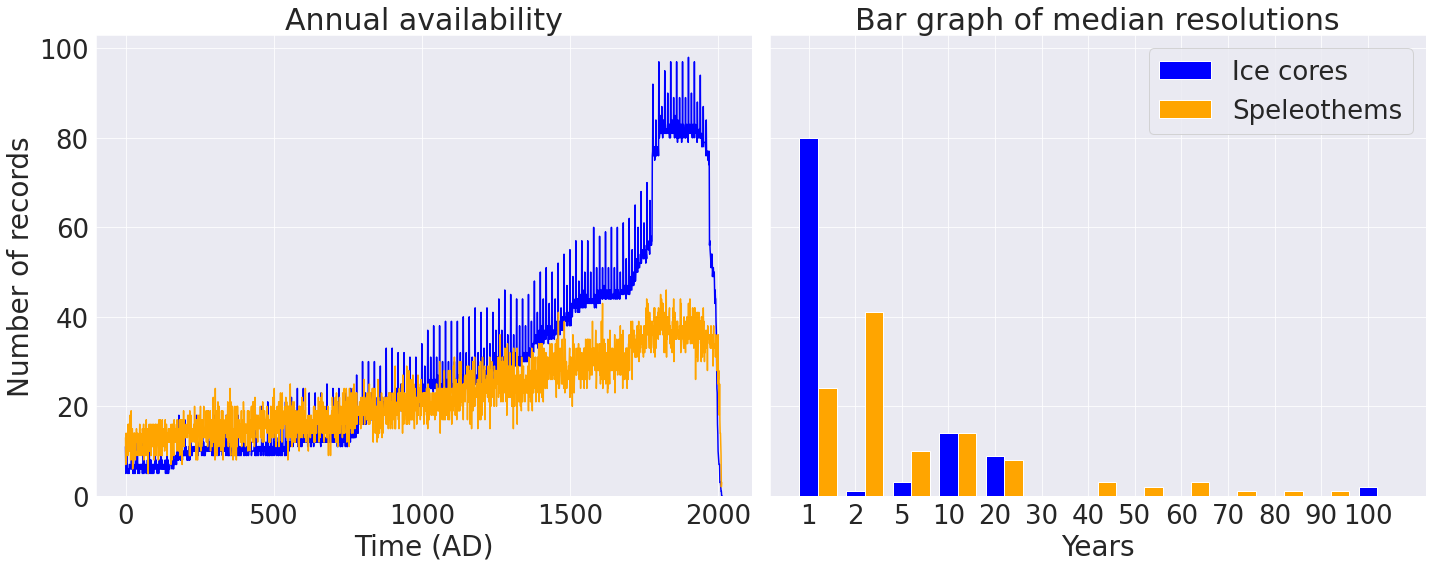

In [7]:
bins=np.concatenate([[1,2,5],np.arange(10,120,10)])
fig=avail_hist([icecores['d18O'],speleothems['d18O']],['Ice cores','Speleothems'],'',bins=bins,colors=['blue','orange'],savefig=None)

In [8]:
fig.savefig(result_path+'record_resol.pdf', format='pdf',bbox_inches='tight')

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


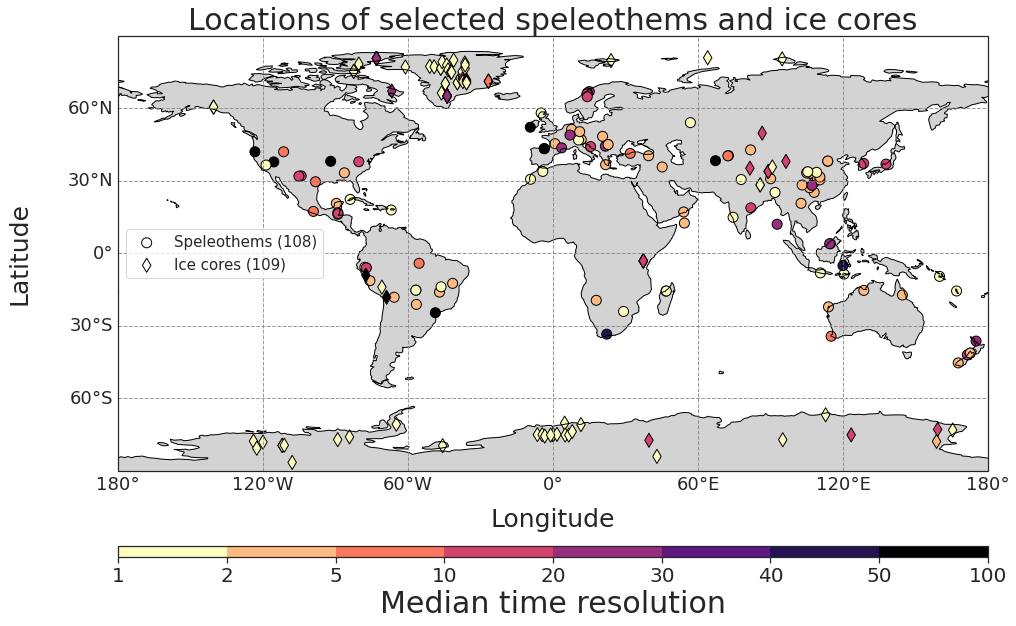

In [8]:
fig_locs=location_plots([speleothems,icecores],['Speleothems','Ice cores'],'Locations of selected speleothems and ice cores',markers=['o','d'],savefig=None)

In [9]:
fig_locs.savefig(result_path+'record_locations.pdf', format='pdf',bbox_inches='tight')

# GISS Drift plot
- Plot standard deviation
- mean for specific regions

In [25]:

        
def clean_d18O(data,lims_global=(-75,20),lims_low_latitudes=(-30,20),low_lats=(-50,50)):
    #Input: data is a DataArray
    print('Counting nan percentage without any cleaning (in %):')
    nans=np.count_nonzero(np.isnan(data.values.flatten()))/len(data.values.flatten())*100
    print(nans)
    lim1=lims_global[0]
    lim2=lims_global[1]
    
    nans0=np.count_nonzero(np.isnan(data))
    data=data.where(data>lim1,np.nan)
    nans1=np.count_nonzero(np.isnan(data))

    print('Counting nans after min extreme masking (',lim1,')')
    nan_counter(data)
    print('New nans after last step',nans1-nans0)
    
    data=data.where(data<lim2,np.nan)
    nans2=np.count_nonzero(np.isnan(data))

    print('Counting nans after max extreme masking (',lim2,')')
    nan_counter(data)
    print('New nans after last step',nans2-nans1)
    
    if lims_low_latitudes is not None:

        #lower latituds cleaning
        low_lat1=low_lats[0]
        low_lat2=low_lats[1]
        mini=lims_low_latitudes[0]
        maxi=lims_low_latitudes[1]

        mask1=xr.where(data.lat>low_lat1,1,0) 
        mask2=xr.where(data.lat<low_lat2,1,0) 
        lats=data.lat[mask1 == mask2]
        data_few=data.sel(lat=lats)
        data.loc[dict(lat=lats)]=xr.where(data_few<mini,np.nan,data_few)
        data_few=data.sel(lat=lats)
        data.loc[dict(lat=lats)]=xr.where(data_few>maxi,np.nan,data_few)

        nans3=np.count_nonzero(np.isnan(data))
        print('Count nan after low_latitudes cleaning')
        nan_counter(data)
        print('New nans after last step',nans3-nans2)
    return data

def nan_counter(data):
    """
    Count nan values, plot max, min and mean
    """
    x=data.copy()
    nans=np.count_nonzero(np.isnan(x))
    total=len(x.values.flatten())
    print(x.name,', nans:',nans, 'percentage:',nans/total*100,' %')
    
def mapplot(xarray,title=None):
    """
    xarray is a DataArray or a numpy array
    """
    #mpl.rcParams['xtick.labelsize'] = 30
    #mpl.rcParams['ytick.labelsize'] = 30
    
    vmax=np.nanpercentile(xarray,97.5)
    vmin=np.nanpercentile(xarray,2.5)
    fig = plt.figure(figsize=(12,9))
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':r'$\delta^{18}$O$^2$'}
    p=xarray.plot(transform=ccrs.PlateCarree(),
                                     subplot_kws={'projection': ccrs.Robinson()},
               robust=True,
                #cbar_kwargs=cbar_kwargs,
                add_colorbar=False,
                vmax=vmax,vmin=vmin
               ) # <--- Change Projection here
    cb=plt.colorbar(p,orientation='horizontal',shrink=0.6,pad=0.02)
    cb.set_label(label=u'‰', size=26)
    cb.ax.tick_params(labelsize='large')
    fig.axes[0].coastlines()
    plt.tight_layout()
    #fig.axes[0].gridlines()
    if title is not None:
        fig.axes[0].set_title(str(title), size=30, family='monospace', variant='small-caps')
        
    return fig

In [26]:
giss_path='/home/mchoblet/raw_data/models/GISS/GISS_d18O_850-1849.nc'
giss=xr.open_dataset(giss_path)['H2O18_in_prec']#.groupby('time.year').mean()
#need to exchange time
time_giss=xr.cftime_range(start='0850',freq='M',periods=len(giss.time), calendar='365_day')

giss=clean_d18O(giss,lims_global=(-75,20),lims_low_latitudes=(-30,20),low_lats=(-50,50))

giss['time']=time_giss
giss=giss.groupby('time.year').mean()

Counting nan percentage without any cleaning (in %):
0.0
Counting nans after min extreme masking ( -75 )
H2O18_in_prec , nans: 74 percentage: 4.758230452674897e-05  %
New nans after last step 74
Counting nans after max extreme masking ( 20 )
H2O18_in_prec , nans: 465870 percentage: 0.29955632716049385  %
New nans after last step 465796
Count nan after low_latitudes cleaning
H2O18_in_prec , nans: 489385 percentage: 0.31467656893004115  %
New nans after last step 23515


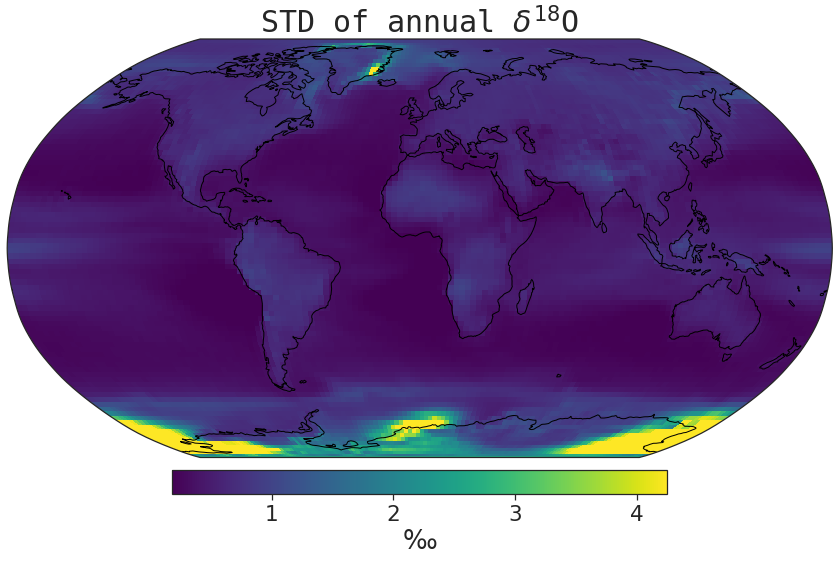

In [22]:
fig_giss=mapplot(giss.std('year',skipna=True),r'STD of annual $\delta^{18}$O')

In [23]:
fig_giss.savefig(result_path+'giss_drift.pdf', format='pdf',bbox_inches='tight')

In [27]:
# Global mean only for specific regions
def wgt_areaave(da, latS, latN):
    lat=da.lat
    iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
    wgt = np.cos(np.deg2rad(lat))
    odat=da.sel(lat=iplat).weighted(wgt).mean(("lon", "lat"), skipna=True)
    
    return(odat)

def wgt_areaave_2(da, latS, latN):
    lat=da.lat
    iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
    wgt = np.cos(np.deg2rad(lat))
    odat=da.sel(lat=list((set(lat.values)-set(iplat.values)))).weighted(wgt).mean(("lon", "lat"), skipna=True)
    return(odat)

def glob_mean(da):
    wgt = np.cos(np.deg2rad(da.lat))
    total_mean=da.weighted(wgt).mean(("lon", "lat"), skipna=True)
    return total_mean

In [28]:
da=giss

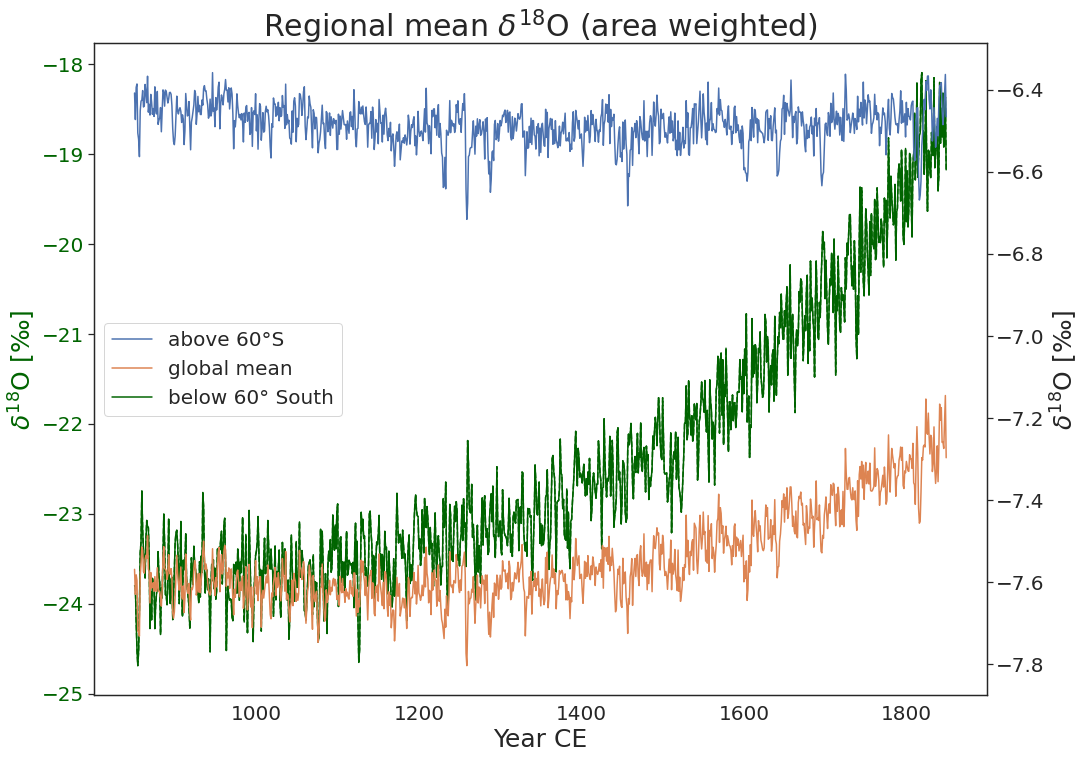

In [32]:
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
da_4040=wgt_areaave(da,-60,90)
da_m4040=wgt_areaave_2(da,-60,90)
sns.set_style('white')

fig=plt.figure(figsize=(16,12))
da_m4040.plot(label='below 60° South',color='darkgreen')

da_m4040.plot(ls='--',color='darkgreen')

#plt.xlabel('Time',fontsize=20)
plt.yticks(color='darkgreen')
plt.ylabel('$\delta^{18}$O [‰]',fontsize=25,color='darkgreen')

ax=plt.gca()
#ax.tick_params(axis='y', colors='darkgreen')

ax2 = ax.twinx()
da_4040.plot(label='above 60°S',ax=ax2)
glob_mean(da).plot(label='global mean',ax=ax2)
#ugly hack
ax2.plot([], [], '-',color='darkgreen',label='below 60° South')

plt.title('Regional mean $\delta^{18}$O (area weighted)',fontsize=30)
plt.legend(fontsize=20,loc='center left')

ax.set_xlabel('Year CE',fontsize=25)
plt.ylabel('$\delta^{18}$O [‰]',fontsize=25)

fig.savefig(result_path+'giss_gmd18O.pdf', format='pdf',bbox_inches='tight')